In [1]:
import xarray as xr

from pydantic import BaseModel, constr, field_validator, ValidationInfo, model_validator
from datetime import datetime
from typing import List, Any, Optional
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
class HydCal(BaseModel):
    refdes: constr(min_length=27, max_length=27)
    deployment: str
    asset_id: constr(min_length=17, max_length=17)
    model: str
    sn: int
    cal_date: datetime
    frequencies: List[float]
    sens: List[float] = None
    sens0: List[float] = None
    sens90: List[float] = None
    ds: Any = None
    rca_bb_offset: float = 128.9

    @model_validator(mode="after")
    def convert_date(self):
        """Convert cal_date to an ISO 8601 string immediately after instantiation."""
        self.cal_date = self.cal_date.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
        return self  # Must return self in a model validator

    @field_validator("frequencies", mode="before")
    @classmethod
    def convert_freqs(cls, values):
        """Convert kHz to Hz by multiplying each element by 1000."""
        return [v * 1000 for v in values]

    @field_validator("sens")
    @classmethod
    def check_lengths(cls, v, info):
        if "frequencies" in info.data and len(v) != len(info.data["frequencies"]):
            raise ValueError("sens and frequencies must be the same length")
        return v

    def make_ndarray(self):
        if self.sens is not None:
            print("creating only a single sensitivity data var")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity": (["frequency"], self.sens),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
        elif self.sens0 is not None and self.sens90 is not None:
            print("creating both 0 and 90 degree sensitivities")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity_0": (["frequency"], self.sens0),
                "sensitivity_90": (["frequency"], self.sens90),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
            

    def save_cal(self):
        self.ds.to_netcdf(f"../metadata/cals/{refdes}_{deployment}.nc", mode="w")

    def save_correction_cal(self):
        if self.sens is not None:
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 
        elif self.sens0 is not None and self.sens90 is not None:
            self.ds["sensitivity"] = (self.ds["sensitivity_0"] + self.ds["sensitivity_90"]) / 2
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 

        self.ds.to_netcdf(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc", mode="w")
        
        

In [3]:
refdes = "CE02SHBP-LJ01D-11-HYDBBA106"
deployment = "1"

In [4]:
asset_id = "ATOSU-58324-00014"
model = "SB2-ETH"
sn = 1248
cal_date = datetime(2013, 8, 2)  # Year, Month, Day
frequency = [
    0.0,
    13.5,
    27.1,
    40.6,
    54.1,
    67.7,
    81.2,
    94.7,
    108.3,
    121.8,
    135.3,
    148.8,
    162.4,
    175.9,
    189.4,
    200.0
]
sensitivity = [
    -175.1,
    -175.1,
    -174.5,
    -174.6,
    -173.5,
    -176.9,
    -176.4,
    -176.1,
    -174.0,
    -175.3,
    -173.1,
    -171.1,
    -163.4,
    -162.7,
    -172.2,
    -174.4
]

In [5]:
hyd = HydCal(
    refdes=refdes,
    deployment=deployment,
    asset_id=asset_id,
    model=model,
    sn=sn,
    cal_date=cal_date,
    frequencies = frequency,
    sens=sensitivity,
    )

hyd.make_ndarray()

creating only a single sensitivity data var


In [6]:
hyd.cal_date

'2013-08-02T00:00:00.000000Z'

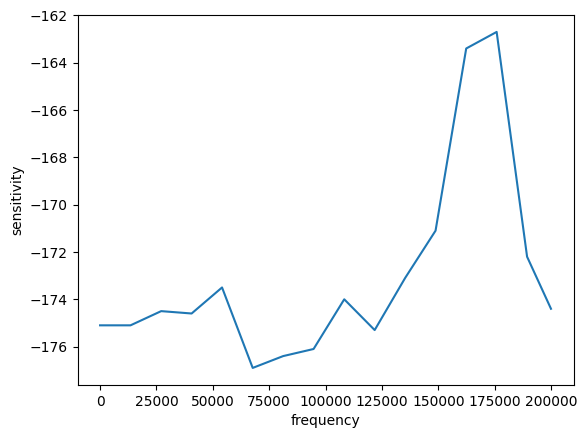

In [7]:
hyd.ds.sensitivity.plot()  # Plot the DataArray

In [8]:
hyd.save_cal()
hyd.save_correction_cal()

In [9]:
test = xr.open_dataset("../metadata/rca_correction_cals/CE02SHBP-LJ01D-11-HYDBBA106_1.nc")

In [10]:
test

<xarray.Dataset>
Dimensions:      (frequency: 16)
Coordinates:
  * frequency    (frequency) float64 0.0 1.35e+04 2.71e+04 ... 1.894e+05 2e+05
Data variables:
    sensitivity  (frequency) float64 ...
Attributes:
    model:             SB2-ETH
    serial number:     1248
    calibration date:  2013-08-02T00:00:00.000000Z